# Movie Recommendation based on Collaborative filtering

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

# Calling the dataset

In [10]:
df = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
movies = pd.read_csv('movies.csv')

In [12]:
df.head(5)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [13]:
df.describe()


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [14]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Mapping user ID to a "user vector" from an embedding matrix

In [15]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

Mapping movies ID to a "movies vector" from an embedding matrix

In [17]:
movie_ids = df["movieId"].unique().tolist()


In [18]:
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

In [19]:
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

In [20]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)


In [21]:
df['rating'] = df['rating'].values.astype(np.float32)

Using Minimum and maximum ratings  to normalize the ratings later

In [22]:
min_rating = min(df["rating"])
max_rating = max(df["rating"])

In [23]:
print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Number of users: 610, Number of Movies: 9724, Min Rating: 0.5, Max Rating: 5.0


# Preparation of required data

In [24]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values


Normalizing the targets between 0 and 1. This will Makes it easy to train

In [25]:
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

Assuming training on 90% of the data and validating on 100%

In [26]:
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# Creating the model

In [39]:

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to be between 0 and 11
        return tf.nn.sigmoid(x)
    
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

# Training the model on the data split

In [44]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
#     verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/5
1418/1418 [==============================] - 3s 2ms/step - loss: 0.5955 - val_loss: 0.6044
Epoch 2/5
1418/1418 [==============================] - 3s 2ms/step - loss: 0.5941 - val_loss: 0.6042
Epoch 3/5
1418/1418 [==============================] - 3s 2ms/step - loss: 0.5929 - val_loss: 0.6037
Epoch 4/5
1418/1418 [==============================] - 3s 2ms/step - loss: 0.5918 - val_loss: 0.6033
Epoch 5/5
1418/1418 [==============================] - 3s 2ms/step - loss: 0.5911 - val_loss: 0.6032


Plotting the model

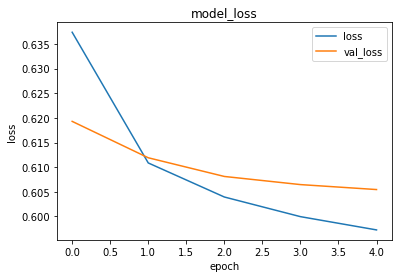

In [41]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

# Top 10 Movie recommendation

In [42]:
movie_df = pd.read_csv('movies.csv')

user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[~movie_df['movieId'].isin(movies_watched_by_user.movieId.values)]['movieId']

movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

user_encoder = user2user_encoded.get(user_id)

user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

In [43]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 520
Movies with high ratings from user
--------------------------------
Shawshank Redemption, The (1994) : Crime|Drama
Monty Python and the Holy Grail (1975) : Adventure|Comedy|Fantasy
Alien (1979) : Horror|Sci-Fi
Metropolis (1927) : Drama|Sci-Fi
Dr. Horrible's Sing-Along Blog (2008) : Comedy|Drama|Musical|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Schindler's List (1993) : Drama|War
Silence of the Lambs, The (1991) : Crime|Horror|Thriller
Reservoir Dogs (1992) : Crime|Mystery|Thriller
Apocalypse Now (1979) : Action|Drama|War
Goodfellas (1990) : Crime|Drama
Cool Hand Luke (1967) : Drama
Fight Club (1999) : Action|Crime|Drama|Thriller
